# A simple inverse problem in Earth Observation

The PROSPECT+SAIL models have been used tons of times to retrieve biophysical parameters from optical EO data. PROSPECT models the leaf's reflectance and transmittance as a function of a leaf structural parameter and pigment concentrations. The reflectance and transmittance over the spectrum are then used by SAIL to figure out what happens to photons entering the canopy via a particular direction and leaving by some other direction, and thus allows you to calculate the top of canopy (or bottom of atmosphere, depending on your taste) reflectance as a function of canopy geometry (mostly leaf area index, leaf angle distribution and some soil description). So if PROSAIL is $\mathcal{H}$, all the parameters of PROSAIL can be stored in a vector $\vec{x}$, and some measurements of bottom of atmosphere (BOA) reflectance are $\vec{y}$, we can tweak $\vec{x}$ until we make $\mathcal{H}(\vec{x})$ match $\vec{y}$.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import prosail

import seaborn as sns

from mcmc  import generate_samples

Let's first create some sample data. A reasonable guess at parameter values for a greenish thickish canopy. We run the PROSAIL model and we get the BOA reflectance for our synthetic canopy from 400 to 2500 nm.

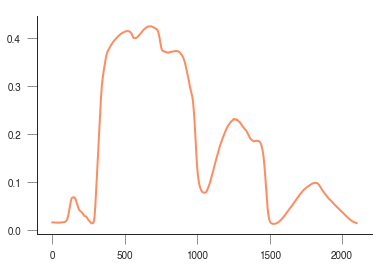

In [2]:
n = 1.8
cab = 37.
car = 8.
cbrown = 0.3
cw = 0.013
cm = 0.005
lai = 3
lidfa = 45.
rho = prosail.run_prosail(n, cab, car, cbrown, cw, cm, lai, lidfa, 
                    0.01, 30., 0., 0.,
                    prospect_version='D',
                    rsoil0=np.zeros(2101))
plt.plot(rho)



Let's simulate something more realistic: some S2A observations. To this end, we need the spectral response functions (SRFs) for the sensor. We'll only select the 10 and 20m bands, as the 60m bands are mostly for cirrus or atmospheric correction.

As part of the simulation, we'll add some Gaussian additive noise to the data.

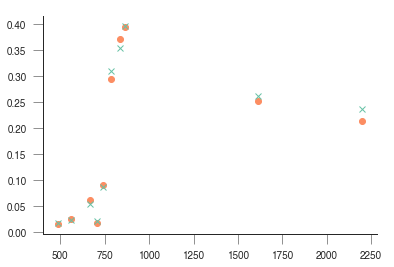

In [3]:
srf = np.loadtxt("S2A_SRS.csv", skiprows=1, delimiter=",")[100:, :]
srf[:, 1:] = srf[:, 1:]/np.sum(srf[:, 1:], axis=0)
srf_land = srf[:, [1, 2, 3, 4, 5, 6, 7, 8, 11, 12]]
wv_land = np.array([486.0, 560.5, 665.0, 704.5, 740.0, 783.0,
                    838.84, 863.25, 1610.5, 2199.0])
#for b in range(13):
#    passer = srf[:,b+1] > 0
#    print(b,srf[passer,0].mean())
rho_s2a = (rho[:, None]*srf_land).sum(axis=0)

rho_s2a_noise = rho_s2a + rho_s2a*0.1*np.random.randn(10)

plt.plot( wv_land, rho_s2a, 'o')
plt.plot( wv_land, rho_s2a_noise, 'x')



So we see that the noise variance scales with reflectance here (so the NIR plateau has a larger "noise" than the visible region). This is (maybe) a realistic observation. We can try to do a simple retrieval. Let's retrieve just two parameters: LAI and $C_{ab}$ (leaf chlorophyll content) from this data. We'll use a Metropolis-Hastings MCMC sampler to do this. Basically, we construct a log-likelihood (formally, a log-posterior, but we'll get to that later), and use the sampler to minimise this function. We have also added a rule that if the parameter goes outside some sanity bounds, the log-likelihood is infinity (so that these potential values are always excluded). **The following snippet takes a while to run**

In [29]:
def logpdf (x):
    if x[1] < 0 or x[1] > 10:
        return np.inf
    if x[0] < 0 or x[0] > 200:
        return np.inf
    rho = prosail.run_prosail(n, x[0], car, cbrown, cw, cm, x[1], lidfa, 
                    0.01, 30., 0., 0.,
                    prospect_version='D',
                    rsoil0=np.zeros(2101))
    rho_pred = (rho[:, None]*srf_land).sum(axis=0)
    xx = rho_pred - rho_s2a_noise
    sigma_obs = rho_s2a*0.1

    return -(0.5*xx**2/sigma_obs**2).sum()


initial_value = [15., 1]
n_iterations = 10000

vals = list(generate_samples(initial_value, n_iterations, logpdf))



Let's see the MH walk. The green dot shows the initial value $(15, 1)$, and we see how the orange line drifts away towards the truth (remember that this was $(37, 3)$). The dense sampling around the fur ball suggests that the log-likelihood has a fairly flat bottom between chlorophyl 30 to 50 and LAI 2 and 4.5 (say). The blue dot is the last point of our travels.

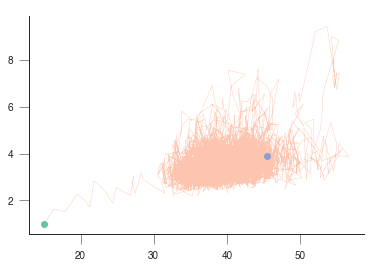

In [35]:
x, y = np.array(vals).T
plt.plot(x, y, '-', lw=0.4, alpha=0.5)
plt.plot(x[0], y[0], 'o')
plt.plot(x[-1], y[-1], 'o')

We can plot this as a kernel density estimator. We now see that the best solution (darkest red) is quite close to the true minimum, but the contour lines around it indicate plausible solutions given the uncertainty. The marginal pdfs tell us something about the possible ranges of the retrieved parameters. And the plot is very pretty too.

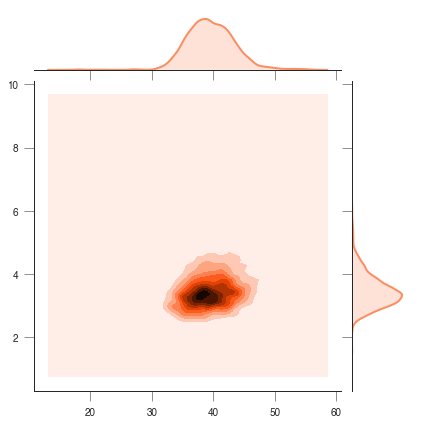

In [31]:
x, y = np.array(vals).T
sns.jointplot(x=x, y=y, kind='kde')


The previous example is a sanity-check: we used the same model to produce the observations and to retrieve the data, the uncertainty was well characterised... But in reality, you can see that in `logpdf` we fixed all parameters to the true values except LAI and $C_{ab}$. So it's a bit cheating ;-/

What would happen if we got one of the parameters wrong? For example, if the brown pigment was higher than the real one. We can run the same example below and see what comes out of it.

In [21]:
def logpdf (x):
    if x[1] < 0 or x[1] > 10:
        return np.inf
    if x[0] < 0 or x[0] > 200:
        return np.inf
    rho = prosail.run_prosail(n, x[0], car, 0.9, cw, cm, x[1], lidfa, 
                    0.01, 30., 0., 0.,
                    prospect_version='D',
                    rsoil0=np.zeros(2101))
    rho_pred = (rho[:, None]*srf_land).sum(axis=0)
    xx = rho_pred - rho_s2a_noise
    sigma_obs = rho_s2a*0.1
    
    return -(0.5*xx**2/sigma_obs**2).sum()


initial_value = [15., 1]
n_iterations = 10000

vals = list(generate_samples(initial_value, n_iterations, logpdf))


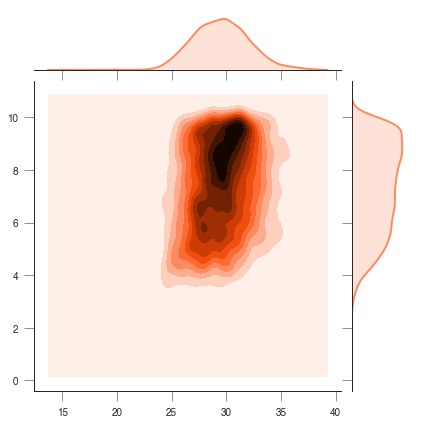

In [28]:
x, y = np.array(vals).T
sns.jointplot(x=x, y=y, kind='kde')


Oh dear... The "likelihood" is now a big gaping scar, and we can see that while $C_{ab}$ is reasonably well retrieved (thanks red edge!), the LAI is actually very poorly retrieved: we can only say that it's above 3 and 10. So this means that model error is critical, and in general, that we can't expect to invert models by just searching for a couple of parameters: we need to constrain the other parameters and hope that the observations have sufficient information so that we can retrieve all of them at the same time, *hope* being the important word.

